In [1]:
import os
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
from scipy.stats import fisher_exact
import seaborn as sns

/pool01/conda/envs/enrollhd/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
os.chdir('/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/')

# Output directory
out_dir = "ml_results/classification/v2/paperfigs/"

# Figure 1

In [ ]:
# Load model parameters
with open('/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ml_results/classification/CAG2_linear_regression_params.pkl', 'rb') as f:
    coeffs = pickle.load(f)

# Sex and CAG vectors
sexCAG = np.load('features/sexCAG.npy')
cag_all = sexCAG[:,1]
cag_squared = cag_all**2
X = np.vstack([np.ones(len(cag_all)), cag_all, cag_squared]).T

# AO values
y_all = pd.read_csv('features/aoo.txt', sep='\t')
y_all = y_all['Onset.Age'].values

y_pred = X.dot(coeffs)

cag_fine = np.linspace(min(cag_all), max(cag_all), 500)
cag_squared_fine = cag_fine ** 2
X_fine = np.vstack([np.ones(len(cag_fine)), cag_fine, cag_squared_fine]).T

# Predicted values for the smoother curve
y_pred_fine = X_fine.dot(coeffs)

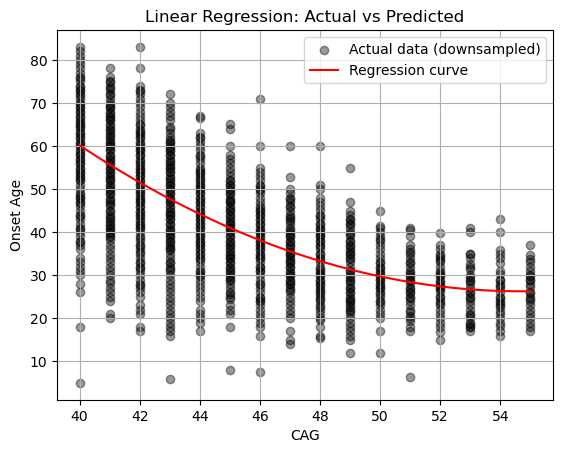

In [24]:
def downsample_points(x, y, grid_size=0.5):
    """
    Downsamples (x, y) points by keeping only one point per grid cell.
    
    Parameters:
        x, y: Input data (1D arrays).
        grid_size: Size of the grid cell in axis units.

    Returns:
        x_ds, y_ds: Downsampled points.
    """
    # Create a grid by rounding coordinates to nearest grid_size
    x_grid = (np.array(x) / grid_size).astype(int)
    y_grid = (np.array(y) / grid_size).astype(int)
    coords = list(zip(x_grid, y_grid))
    
    # Use a dictionary to keep one point per grid cell
    seen = {}
    for i, coord in enumerate(coords):
        if coord not in seen:
            seen[coord] = i
    
    indices = list(seen.values())
    return np.array(x)[indices], np.array(y)[indices]

# Apply to your data
cag_ds, y_ds = downsample_points(cag_all, y_all, grid_size=0.5)

# Plot downsampled scatter
plt.grid(True)
plt.scatter(cag_ds, y_ds, color='black', alpha=0.4, label='Actual data (downsampled)')
plt.plot(cag_fine, y_pred_fine, color='red', label='Regression curve')
plt.xlabel('CAG')
plt.ylabel('Onset Age')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.savefig(f"{out_dir}cag_regression.pdf", dpi=300, bbox_inches='tight')


### Panell B

In [7]:
residuals = pd.read_csv('features/AO_quadratic_residuals.txt', header=None).squeeze()
residual_bins = pd.qcut(residuals, q=5, labels=False)  # Labels are 0 to 4 by default

# Define a colormap
colors = sns.color_palette("viridis", n_colors=5)

labels_strings = ['Much earlier than expected', 'Earlier than expected', 'As expected', 'Later than expected', 'Much later than expected']

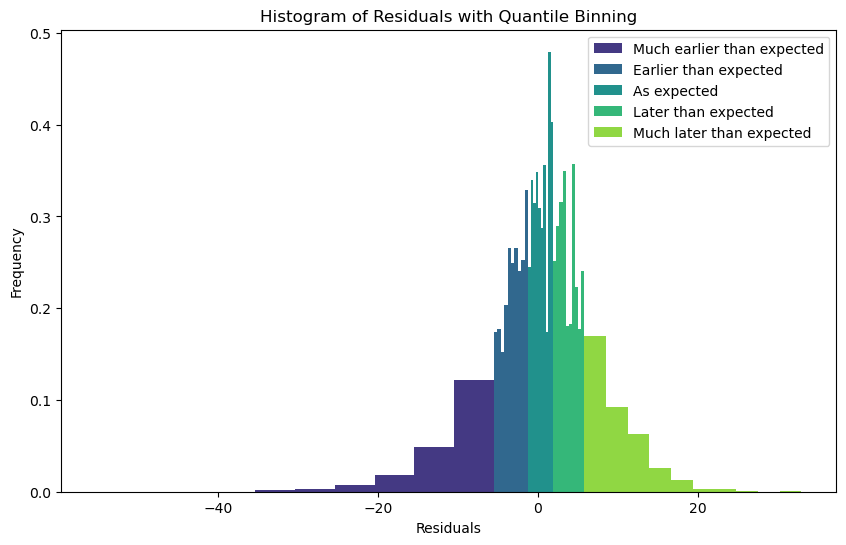

In [8]:
# Plot histogram
plt.figure(figsize=(10, 6))
for i in range(5):  # Loop through each bin
    plt.hist(residuals[residual_bins == i], density=True, color=colors[i],  label=labels_strings[i])

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals with Quantile Binning")
plt.legend()
plt.savefig("/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ml_results/classification/v2/paperfigs/class_histogram.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Figure 2

### Panell A

In [3]:
os.chdir('/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/')

# Data directory
data_dir = "features/"

# Path to models
model_dir = "ml_results/classification/v2/xgboosts/"

# Path to output directory
feat_dir = "ml_results/classification/v2/" 

# Read feature contributions
feat_importances = pd.read_csv(f"{feat_dir}b1_xgboost_total_importance.txt", sep="\t")

# Read metrics table
metrics = pd.read_csv(f"{feat_dir}xgboost_metrics_summary.txt", sep="\t")

# Read SNP lookup table
snp_lookuptab = pd.read_csv("genes/snps_gene_GO_m3.txt", sep="\t")

In [4]:
# Fill missing GO terms
snp_lookuptab["GO_term"] = snp_lookuptab["GO_term"].fillna("extra_genes")

gene_map = dict(zip(snp_lookuptab['SNP'], snp_lookuptab['Gene']))
go_term_map = dict(zip(snp_lookuptab['SNP'], snp_lookuptab['GO_term']))
gene_to_go_term = dict(zip(snp_lookuptab['Gene'], snp_lookuptab['GO_term']))

In [ ]:
results_dir = "/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ml_results/classification/v2/benchmark/"
xb_file_path = "/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ml_results/classification/v2/xgboost_metrics_summary.txt"
lr_file_path = "/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ml_results/classification/v2/logisticregression_metrics_summary.txt"
gnns_file_path = "/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/gnn/classification/gnn_metrics_summary.txt"

lr = pd.read_csv(lr_file_path, sep="\t")
xb = pd.read_csv(xb_file_path, sep="\t")
gnns = pd.read_csv(gnns_file_path, sep="\t")

# Identify model types
lr["Model Type"] = lr["Model"].apply(lambda x: "b1" if "b1" in x else 
                                     ("b2" if "b2" in x else "Other"))
xb["Model Type"] = xb["Model"].apply(lambda x: "b1" if "b1" in x else 
                                     ("b2" if "b2" in x else "Other"))

# Record model seed
lr["Seed"] = lr['Model'].str.extract(r'_(\d+)$').astype(int)
xb["Seed"] = xb['Model'].str.extract(r'_(\d+)$').astype(int)

# Filter only b1 and b2 models
lr = lr[lr["Model Type"].isin(["b1", "b2"])]
xb = xb[xb["Model Type"].isin(["b1", "b2"])]

# Convert columns to numeric
lr["Accuracy"] = pd.to_numeric(lr["Accuracy"])
xb["Accuracy"] = pd.to_numeric(xb["Accuracy"])
lr["Train Balanced Accuracy"] = pd.to_numeric(lr["Train Balanced Accuracy"])
xb["Train Balanced Accuracy"] = pd.to_numeric(xb["Train Balanced Accuracy"])
lr["LR"] = pd.to_numeric(lr["LR"])
lr["Lambda_L1"] = pd.to_numeric(lr["Lambda_L1"])
xb["Depth"] = pd.to_numeric(xb["Depth"])
xb["LR"] = pd.to_numeric(xb["Learning Rate"])
xb = xb.drop(columns=["Learning Rate"])

# Convert additional columns to numeric
columns_to_convert = ["Precision", "Recall", "F1-Score", "Support"]
for col in columns_to_convert:
    lr[col] = pd.to_numeric(lr[col])
    xb[col] = pd.to_numeric(xb[col])

# Combine datasets
lr["Model"] = "Logistic Regression"
xb["Model"] = "XGBoost"
gnns["Model"] = gnns["Model_Seed"].apply(lambda x: "GNNConvDropoutPool" if "GNNConvDropoutPool" in x else 
                                     ("EdgeGAT" if "EdgeGAT" in x else "Other"))
gnns["Seed"] = gnns['Model_Seed'].str.extract(r'_(\d+)$').astype(int)
gnns = gnns.drop(columns = "Model_Seed")
gnns["Model Type"] = 'b2'
combined = pd.concat([lr, xb, gnns], ignore_index=True)
combined.to_csv(f"{results_dir}combined_performances.txt", sep= "\t", index = False)

best_models = combined.loc[combined.groupby('Model')['Accuracy'].idxmax()]

In [ ]:
# Benchmark 1
plt.figure(figsize=(8, 6))
sns.violinplot(x="Model", y="Accuracy", data=combined[combined["Model Type"] == "b1"])
plt.title("SNPs genotype features benchmark")
plt.ylabel("Testing Balanced Accuracy")
plt.ylim(0.18, 0.3)
plt.savefig(f"{results_dir}b1_accuracy_comparison.png")
plt.savefig(f"ml_results/classification/v2/paperfigs/b1_accuracy_comparison.pdf", dpi = 300)
plt.show()

In [ ]:
from scipy.stats import wilcoxon

# Wilcoxon test of b1 models
subset = combined[combined["Model Type"] == "b1"]

# Make sure the data is aligned by index or sample ID
paired_data = subset.pivot(index='Seed', columns='Model', values='Accuracy')  # adjust if needed

stat, p = wilcoxon(paired_data["Logistic Regression"], paired_data["XGBoost"])
print(f"Wilcoxon test statistic: {stat}, p-value: {p}")

### Panell B

Extract the top 20 genes and save object to plot in gephi.

In [5]:
# Extract feature matrix header
with open(data_dir + "subsetting/header_feature_matrix_m3_filt_0.01.txt", "r") as file:
    header = file.readline().strip().split("\t")
feature_names = header[1:]

def load_model(seed, dataset="b1"):
    # Load the model    
    model_path = f"{model_dir}{dataset}_ES_xgboost_{seed}_model.json"
    xgb_booster = xgb.Booster()
    xgb_booster.load_model(model_path)

    # Load trees
    model_trees = f"{model_dir}{dataset}_ES_xgboost_{seed}_trees.csv"
    trees = pd.read_csv(model_trees, sep="\t", index_col=0)

    return xgb_booster, trees

In [6]:
xgb_booster, trees = load_model(45, "b1")

In [29]:
# Read adjacecny matrix of ppi
with open("/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ppi_networks/protein_interactions_matrix_filtered.pkl", "rb") as f:
    ppi_matrix = pickle.load(f)
node_idxs = pd.read_csv("/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ppi_networks/protein_interactions_matrix_index_mapping.csv")

In [7]:
gain_importances = xgb_booster.get_score(importance_type='gain')
gain_importances_list = [[feature_names[int(key[1:])], value] for key, value in gain_importances.items()]
gain_importances_list = sorted(gain_importances_list, key=lambda x: x[1], reverse=True)

booster_important_snps = pd.DataFrame(columns=['SNP','Gain','Gene','GO'])

# Take top 100 snps
for snp, gain in gain_importances_list:
    # skip CAG contribution
    if snp == 'CAG':
        continue
    # Find snp in lookup table
    match = snp_lookuptab[snp_lookuptab["SNP"] == snp]
    # Retrieve corresponding gene and GO term
    gene, GO = match['Gene'].values[0], match['GO_term'].values[0]
    # Create new row in pd df
    row = {'SNP':snp, 'Gain':gain, 'Gene':gene, 'GO':GO}
    booster_important_snps = booster_important_snps._append(row, ignore_index=True)

booster_important_snps

/tmp/ipykernel_1285861/4118857059.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  booster_important_snps = booster_important_snps._append(row, ignore_index=True)


,SNP,Gain,Gene,GO
0,rs11293,17.052387,FAN1,GO:0006298
1,rs61997076,11.581249,FAN1,GO:0006298
2,rs167858,11.483575,NRG1,GO:0140110
3,rs245105,11.146414,DHFR,GO:0046655
4,rs7078374,10.693563,ARID5B,GO:0140110
...,...,...,...,...
191,rs45556043,6.785206,CIITA,GO:0140110
192,rs2370133,6.784683,ZIM3,GO:0140110
193,rs9436302,6.783938,LEPR,GO:0006112
194,rs73568119,6.768782,LIG1,GO:0006298


In [ ]:
# Get the top N genes based on feature importance
top_genes = booster_important_snps["Gene"].unique()[:20]
top_genes

array(['FAN1', 'NRG1', 'DHFR', 'ARID5B', 'MLH1', 'TCERG1', 'ZFHX3',
       'RORA', 'MED23', 'ESRRB', 'HTT', 'HIVEP3', 'ZNF423', 'CAMTA1',
       'TNR', 'CUX1', 'GLIS3', 'CCAR1', 'LIG1', 'GRIN2B'], dtype=object)

In [10]:
# Map genes to their corresponding index values in node_idxs
top_genes_indices = node_idxs[node_idxs['alias'].isin(top_genes)]
top_genes_indices_list = top_genes_indices['Index'].tolist()

# Filter the ppi_matrix to include only the top genes
filtered_ppi_matrix = ppi_matrix[top_genes_indices_list, :][:, top_genes_indices_list]
# Convert sparse matrix to numpy array
filtered_ppi_matrix = filtered_ppi_matrix.todense()

In [11]:
# Create graph from adjacency matrix
G = nx.from_numpy_array(filtered_ppi_matrix)

unique_go_terms = {term: idx for idx, term in enumerate(set(snp_lookuptab['GO_term']))}

# Add attributes to each node
for idx, alias in enumerate(top_genes_indices['alias']):
    G.nodes[idx]['label'] = alias  # Human-readable label
    G.nodes[idx]['score'] = booster_important_snps[booster_important_snps['Gene']==alias]['Gain'].max() # Node size
    go_term = gene_to_go_term.get(alias, "Unknown")
    G.nodes[idx]['GO_term'] = go_term
    G.nodes[idx]['GO_term_id'] = unique_go_terms.get(go_term, -1) 
    
# Optional: normalize edge weights (if needed in Gephi)
for u, v, d in G.edges(data=True):
    d['weight'] = d.get('weight', 1.0)

# Save to GEXF
nx.write_gexf(G, f"{out_dir}ppi_graph_b1_xgb_45.gexf")

### Panell C

In [ ]:
GO_names = {'GO:0006298': 'DNA maintenance',
            'GO:0035249': 'Glutamatergic synaptic transmission',
            'GO:0008242': 'Omega peptidase activity',
            'GO:0004197': 'Cysteine-type endopeptidase activity',
            'GO:0043161': 'Ubiquitin-dependant protein catabolic process',
            'GO:0043130': 'Ubiquitin binding',
            'GO:0031625': 'Ubiquitin protein ligase binding',
            'GO:0016579': 'Protein deubiquitination',
            'GO:0140110': 'Transcription regulator activity',
            'GO:0051402': 'Neuron apoptotic process',
            'GO:0042157': 'Lipoprotein metabolic process',
            'GO:0098930': 'Axonal transport',
            'GO:0046655': 'Folic acid metabolism',
            'GO:0006112': 'Energy reserve metabolism'}

In [8]:
# top_booster_important_snps = booster_important_snps[booster_important_snps['Gene'].isin(top_genes)].drop_duplicates(subset='Gene', keep='first')
# len(top_booster_important_snps)
top_booster_important_snps =  booster_important_snps[:100]

In [ ]:
# top_booster_important_snps.to_excel(f"{out_dir}top100_45.xlsx")

In [17]:
# Convert snps_feature_names to a df
snps_df = pd.DataFrame(feature_names, columns=['SNP'])

# Drop duplicates from snp_lookuptab based on the SNP column
snp_lookuptab_unique = snp_lookuptab.drop_duplicates(subset=['SNP'])

# Merge snps_df with the deduplicated snp_lookuptab on the SNP column
model_snps = snps_df.merge(snp_lookuptab_unique, on='SNP', how='left')

# Rename GO column
model_snps = model_snps.rename(columns={'GO_term': 'GO'})

# Drop columns from CAG and sex
model_snps = model_snps[~model_snps["SNP"].isin(["CAG", "Sex"])]

background = model_snps['GO'].value_counts()

distributions = []

# Append background GO percentages
distributions.append(background)

# Calculate the percentage distribution of GO categories in the top20 of the best model

go_counts = top_booster_important_snps['GO'].value_counts()
distributions.append(go_counts)

model_names_bg = ['Background', "b1_xgboost_45"]

# Combine distributions into a single DataFrame
combined_df = pd.DataFrame(distributions).T.fillna(0)
combined_df.columns = model_names_bg

# Add 1 to all values to avoid having 0 counts
combined_df = combined_df + 1

# Column Total
combined_df_modeltotal = combined_df.sum()

combined_df_modeltotal

Background       339876.0
b1_xgboost_45       114.0
dtype: float64

In [18]:
combined_df

,Background,b1_xgboost_45
GO,,
GO:0140110,202235.0,67.0
GO:0043161,26519.0,5.0
GO:0031625,20293.0,7.0
GO:0035249,18047.0,7.0
GO:0098930,14880.0,2.0
GO:0051402,14807.0,4.0
GO:0042157,10931.0,2.0
GO:0004197,9015.0,2.0
GO:0006112,6285.0,3.0


In [19]:
# Perform Fisher's exact test for each GO term against the background
pval_results = {}
odds_results = {}

for go_term in combined_df.index:
    go_proportions = combined_df.loc[go_term].drop('Background')  # Exclude 'Background' column
    background_count = combined_df.loc[go_term, 'Background']
    p_values = {}
    odds = {}
    for model, proportion in go_proportions.items():
        # Contingency table assembly
        contingency_tab = [[proportion, combined_df_modeltotal[model] - proportion], [background_count, combined_df_modeltotal['Background'] - background_count]]
        
        # Fisher test
        oddsratio, p_value = fisher_exact(contingency_tab)
        
        # Save results in corresponding vectors
        p_values[model] = p_value
        odds[model] = oddsratio
        
    # Add result vector to dictionary
    pval_results[go_term] = p_values
    odds_results[go_term] = odds

# Convert results to DataFrame
pval_results_df = pd.DataFrame(pval_results)
odds_results_df = pd.DataFrame(odds_results)

odds_results_df = odds_results_df.round(4).T
result = pval_results_df.round(4).T

# Replace indices with corresponding names
odds_results_df.index = odds_results_df.index.map(GO_names)
result.index = result.index.map(GO_names)

odds_hist = odds_results_df['b1_xgboost_45']
p_hist = result['b1_xgboost_45']

In [23]:
import math
odds_hist = odds_hist.apply(lambda x: math.log10(x))
combined_hist = pd.DataFrame({'odds':odds_hist, 'pvals':p_hist})

# Sort the combined DataFrame by the absolute value of OddsRatio in descending order
combined_hist['abs_odds'] = abs(combined_hist['odds'])
combined_hist = combined_hist.sort_values(by='abs_odds', ascending=False)
# drop the odds absolute value column
combined_hist = combined_hist.drop('abs_odds', axis=1)

combined_hist

,odds,pvals
Folic acid metabolism,0.898303,0.0072
DNA maintenance,0.821199,0.0000
Axonal transport,-0.408935,0.2474
Omega peptidase activity,0.386766,0.3387
Ubiquitin binding,-0.324038,0.7274
Lipoprotein metabolic process,-0.269702,0.5916
Ubiquitin-dependant protein catabolic process,-0.266001,0.2201
Cysteine-type endopeptidase activity,-0.183494,0.7729
Energy reserve metabolism,0.156701,0.4719
Protein deubiquitination,-0.118958,1.0000


In [24]:
# Determine the colors based on p-value
colors = ['gray' if p < 0.05 else 'lightgray' for p in combined_hist['pvals']]

# Reverse the order to get the largest value at the top
combined_hist = combined_hist[::-1]
colors = colors[::-1]

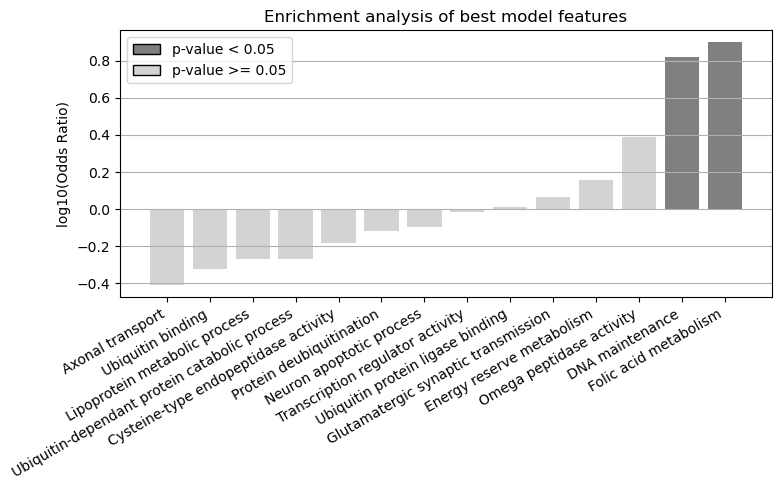

In [26]:
from matplotlib.patches import Patch

# Plot the bar plot
plt.figure(figsize=(8, 5))

# Sort combined_hist by odds value (negative to positive)
combined_hist = combined_hist.sort_values(by='odds')

# Update colors based on the new order
colors = ['gray' if p < 0.05 else 'lightgray' for p in combined_hist['pvals']]

plt.bar(combined_hist.index, combined_hist['odds'], color=colors)
plt.ylabel('log10(Odds Ratio)')
plt.title('Enrichment analysis of best model features')
plt.grid(axis='y')

# Rotate x-axis labels if necessary
plt.xticks(rotation=30, ha='right')

# Create a custom legend
legend_elements = [
    Patch(facecolor='gray', edgecolor='black', label='p-value < 0.05'),
    Patch(facecolor='lightgray', edgecolor='black', label='p-value >= 0.05')
]
plt.legend(handles=legend_elements, loc='upper left')

# Save and show plot
plt.tight_layout()
plt.savefig(f"{out_dir}go_enrichment_45.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Panell E

In [6]:
xgb_booster, trees = load_model(35, "b1")

In [7]:
def unscale_cag(cag):
    """
    Unscale CAG values
    """
    return cag * (55-40) + 40

In [8]:
def rootcag_col_histogram(secondary_split_summary, top_genes):
    """
    Plot a heatmap where each column is a gene and the rows are different root CAG splits.
    The value in the cells corresponds to how many trees are using that gene as a 
    secondary split, having CAG at the root node with a particular split value.
    """
    filtered_df = secondary_split_summary[secondary_split_summary['Gene'].isin(top_genes)]

    # Create pivot table: RootSplit as rows, Gene as columns
    pivot = pd.pivot_table(filtered_df, values='Tree', index='RootSplit', columns='Gene', aggfunc='count', fill_value=0)

    # Histogram column: total counts per RootSplit (row-wise sum)
    pivot.insert(0, 'All', pivot.sum(axis=1))

    # Sort gene columns (excluding 'All') by lowest RootSplit they appear in
    def first_nonzero_index(col):
        return next((i for i, val in enumerate(col) if val > 0), float('inf'))

    gene_order = sorted([gene for gene in pivot.columns if gene != 'All'],
                        key=lambda gene: first_nonzero_index(pivot[gene].values))

    # Reinsert 'All' as the first column
    pivot = pivot[['All'] + gene_order]

    # Plot with matplotlib
    fig, ax = plt.subplots(figsize=(14, 8))
    im = ax.imshow(pivot.values, cmap='Blues')

    # Axis ticks and labels
    ax.set_xticks(np.arange(pivot.columns.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=45, ha="right")

    ax.set_yticks(np.arange(pivot.index.shape[0]))
    ax.set_yticklabels([int(r) for r in pivot.index])  # Ensure y-axis is integer labels

    # Annotate each cell with its value
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha="center", va="center", color="black", fontsize=12)

    # Titles and labels
    ax.set_title("RootSplit vs Top 20 Genes Most Used in 2nd Split")
    ax.set_xlabel("Gene (and Total)")
    ax.set_ylabel("CAG RootSplit")

    fig.tight_layout()
    # plt.show()

    return fig, ax

Get what features are used in the secondary nodes of those trees that use CAG as the splitting feature in their root node.

In [9]:
records = []

# Get all trees where root node is 'f1'
f1_roots = trees[(trees['Node'] == 0) & (trees['Feature'] == 'f1')]

for _, root in f1_roots.iterrows():
    tree_id = root['Tree']
    root_split = unscale_cag(float(root['Split']))

    # Get the IDs of the root's children (second-level nodes)
    second_nodes = trees[
        (trees['Tree'] == tree_id) &
        (trees['ID'].isin([root['Yes'], root['No'], root['Missing']])) &
        (trees['Feature'] != 'Leaf')  # Must be split nodes
    ]

    for _, second in second_nodes.iterrows():
        second_feature = feature_names[int(second['Feature'][1:])]
        second_split = float(second['Split'])
        second_id = second['ID']

        # Get the children of this second-level node (leaves at depth 2)
        leaf_nodes = trees[
            (trees['Tree'] == tree_id) &
            (trees['ID'].isin([second['Yes'], second['No'], second['Missing']])) &
            (trees['Feature'] == 'Leaf')
        ]

        for _, leaf in leaf_nodes.iterrows():
            records.append({
                'Tree': tree_id,
                'RootSplit': root_split,
                'SecondNodeID': second_id,
                'SecondFeature': second_feature,
                'Gene': gene_map.get(second_feature, 'Unknown'),
                'SecondSplit': second_split,
                'LeafNodeID': leaf['ID'],
                'Prediction': leaf['Gain']
            })

# Convert to DataFrame
secondary_split_summary = pd.DataFrame(records)
secondary_split_summary = secondary_split_summary.drop_duplicates("SecondNodeID")
secondary_split_summary

,Tree,RootSplit,SecondNodeID,SecondFeature,Gene,SecondSplit,LeafNodeID,Prediction
0,0,46.0,0-1,rs10779704,RERE,-0.00001,0-3,0.001976
2,0,46.0,0-2,rs141785903,JMJD1C,-0.00001,0-5,-0.002132
4,1,44.0,1-1,rs74731261,TRIM5,-0.00001,1-3,-0.001555
6,1,44.0,1-2,rs62131004,ZNF114,-0.00001,1-5,0.001039
8,2,46.0,2-1,rs145457600,GRIK2,-0.00001,2-3,-0.000829
...,...,...,...,...,...,...,...,...
1690,1194,42.0,1194-2,rs187924949,CAMTA1,-0.00001,1194-5,-0.000531
1692,1195,46.0,1195-1,rs7775674,ARID1B,-0.00001,1195-3,-0.000345
1694,1195,46.0,1195-2,rs73158583,PATZ1,2.00000,1195-5,0.002470
1696,1219,42.0,1219-1,rs12901310,UNC13C,2.00000,1219-3,0.000892


In [ ]:
# Top 20 genes by frequency
top_genes = secondary_split_summary['Gene'].value_counts().head(20).index
top_genes

Index(['FAN1', 'TRIM5', 'HTT', 'ZNF114', 'POU6F2', 'HLF', 'GRIK2', 'SRA1',
       'RERE', 'FHIT', 'JMJD1C', 'NMT1', 'CUL5', 'ASB2', 'MECOM', 'CAMTA1',
       'ZNF160', 'MLH1', 'RHOBTB3', 'SMARCA2'],
      dtype='object', name='Gene')

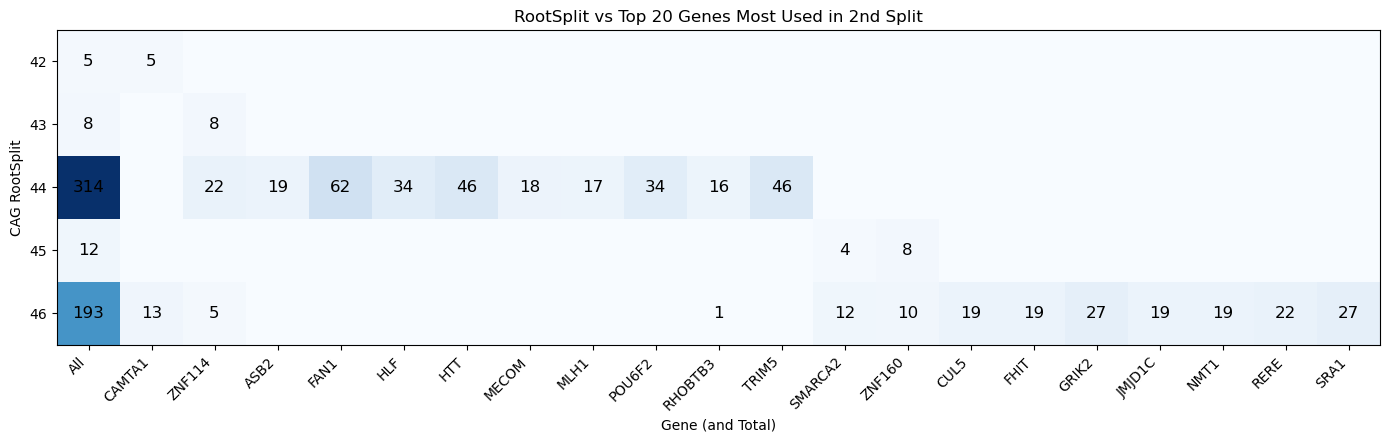

In [11]:
fig, ax = rootcag_col_histogram(secondary_split_summary, top_genes)
fig.savefig(f"{out_dir}rootsplit_vs_2ndfeat_35.pdf", dpi=300)

In [25]:
secondary_split_summary[secondary_split_summary["Gene"]=='ZNF114']

,Tree,RootSplit,SecondNodeID,SecondFeature,Gene,SecondSplit,LeafNodeID,Prediction
6,1,44.0,1-2,rs62131004,ZNF114,-0.00001,1-5,0.001039
22,6,44.0,6-2,rs62131004,ZNF114,-0.00001,6-5,0.001030
38,11,44.0,11-2,rs62131004,ZNF114,-0.00001,11-5,0.001022
54,16,44.0,16-2,rs62131004,ZNF114,-0.00001,16-5,0.001014
86,26,44.0,26-2,rs62131004,ZNF114,-0.00001,26-5,0.000994
118,36,44.0,36-2,rs62131004,ZNF114,-0.00001,36-5,0.000976
150,46,44.0,46-2,rs62131004,ZNF114,-0.00001,46-5,0.000957
182,56,44.0,56-2,rs62131004,ZNF114,-0.00001,56-5,0.000939
214,66,44.0,66-2,rs62131004,ZNF114,-0.00001,66-5,0.000921
230,71,44.0,71-2,rs62131004,ZNF114,-0.00001,71-5,0.000914


### Panell D

Whcich secondary features are used in the left and right branches (smaller or larger than splitting value).

In [11]:
results = []

# For each tree with f1 root
for _, root in f1_roots.iterrows():
    tree_id = root['Tree']
    root_split = root['Split']
    
    yes_node = root['Yes']
    yes_node = int(yes_node.split('-')[-1])
    no_node = root['No']
    no_node = int(no_node.split('-')[-1])
    
    # Get subtree rows for this tree
    subtree = trees[trees['Tree'] == tree_id]

    # Analyze the "Yes" branch
    yes_subnode = subtree[subtree['Node'] == yes_node]
    if not yes_subnode.empty:
        yes_subnode = yes_subnode.iloc[0]
        second_feature = yes_subnode['Feature']
        second_feature_num = int(second_feature[1:])  # assuming format 'f123'
        gene = gene_map.get(feature_names[second_feature_num], 'Unknown')
        results.append({
            'Tree': tree_id,
            'Root_Split': int(unscale_cag(root_split)),
            'Branch': 'Smaller',  # means f1 <= split
            'Subnode_ID': yes_node,
            'Subnode_Feature': gene,
            'Subnode_Split': yes_subnode['Split']
        })
    
    # Analyze the "No" branch
    no_subnode = subtree[subtree['Node'] == no_node]
    if not no_subnode.empty:
        no_subnode = no_subnode.iloc[0]
        second_feature = no_subnode['Feature']
        second_feature_num = int(second_feature[1:])  # assuming format 'f123'
        gene = gene_map.get(feature_names[second_feature_num], 'Unknown')
        results.append({
            'Tree': tree_id,
            'Root_Split': int(unscale_cag(root_split)),
            'Branch': 'Larger',   # means f1 > split
            'Subnode_ID': no_node,
            'Subnode_Feature': gene,
            'Subnode_Split': no_subnode['Split']
        })

final_df = pd.DataFrame(results)
print(final_df)

     Tree  Root_Split   Branch  Subnode_ID Subnode_Feature  Subnode_Split
0       0          46  Smaller           1            RERE       -0.00001
1       0          46   Larger           2          JMJD1C       -0.00001
2       1          44  Smaller           1           TRIM5       -0.00001
3       1          44   Larger           2          ZNF114       -0.00001
4       2          46  Smaller           1           GRIK2       -0.00001
..    ...         ...      ...         ...             ...            ...
845  1194          42   Larger           2          CAMTA1       -0.00001
846  1195          46  Smaller           1          ARID1B       -0.00001
847  1195          46   Larger           2           PATZ1        2.00000
848  1219          42  Smaller           1          UNC13C        2.00000
849  1219          42   Larger           2            DHFR       -0.00001

[850 rows x 6 columns]


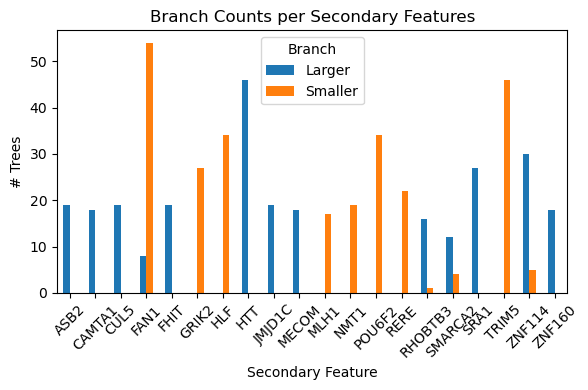

In [27]:
results_filt = final_df[final_df['Subnode_Feature'].isin(top_genes)]

# Count Branch occurrences per Subnode_Feature
counts = results_filt.groupby(['Subnode_Feature', 'Branch']).size().unstack(fill_value=0)

# Plot
counts.plot(kind='bar', figsize=(6, 4))
plt.ylabel('# Trees')
plt.xlabel('Secondary Feature')
plt.title('Branch Counts per Secondary Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{out_dir}splitting_branches_cag.pdf", dpi = 300)
plt.show()

# Figure S1

Repeat figure 2 but with results for all xgboosts with SNP features.

### Panell A

Graph of genes with highest gain across all xgboosts using SNP features.

In [25]:
# Read adjacecny matrix of ppi
with open("/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ppi_networks/protein_interactions_matrix_filtered.pkl", "rb") as f:
    ppi_matrix = pickle.load(f)
node_idxs = pd.read_csv("/pool01/projects/abante_lab/ao_prediction_enrollhd_2024/ppi_networks/protein_interactions_matrix_index_mapping.csv")

In [12]:
# Get importance in all models
all_booster_snps = pd.DataFrame(columns=['SNP', 'Gain', 'Gene', 'GO', 'Seed'])

seed_values = [i for i in range(1,51)]

for seed in seed_values:
    try:
        xgb_booster, trees = load_model(seed, "b1")

        gain_importances = xgb_booster.get_score(importance_type='gain')
        gain_importances_list = [[feature_names[int(key[1:])], value] for key, value in gain_importances.items()]
        gain_importances_list = sorted(gain_importances_list, key=lambda x: x[1], reverse=True)

        count = 0
        for snp, gain in gain_importances_list:
            if snp == 'CAG':
                continue
            match = snp_lookuptab[snp_lookuptab["SNP"] == snp]
            if match.empty:
                continue  # skip if SNP not found
            gene, GO = match['Gene'].values[0], match['GO_term'].values[0]
            row = {'SNP': snp, 'Gain': gain, 'Gene': gene, 'GO': GO, 'Seed': seed}
            all_booster_snps = all_booster_snps._append(row, ignore_index=True)
            count += 1
            if count >= 100:
                break
    except Exception as e:
        print(f"Skipping seed {seed} due to error: {e}")


/tmp/ipykernel_1691625/2238408339.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_booster_snps = all_booster_snps._append(row, ignore_index=True)


In [13]:
# Group by SNP and compute mean Gain
mean_gain_df = all_booster_snps.groupby('SNP', as_index=False)['Gain'].mean()
mean_gain_df = mean_gain_df.rename(columns={'Gain': 'Mean_Gain'})

# Drop duplicates from original to get one Gene/GO per SNP (assumes consistency)
snp_metadata = all_booster_snps[['SNP', 'Gene', 'GO']].drop_duplicates(subset='SNP')

# Merge metadata with mean gains
snp_mean_gain_df = pd.merge(mean_gain_df, snp_metadata, on='SNP')

# sort by mean gain
snp_mean_gain_df = snp_mean_gain_df.sort_values(by='Mean_Gain', ascending=False).reset_index(drop=True)

In [14]:
snp_mean_gain_df

,SNP,Mean_Gain,Gene,GO
0,rs11236183,18.061022,POLD3,GO:0006298
1,rs10152143,18.059406,FAN1,GO:0006298
2,rs12115373,17.885752,RORB,GO:0140110
3,rs12909672,17.843246,RORA,GO:0140110
4,rs9550733,17.700236,ZDHHC20,GO:0042157
...,...,...,...,...
3549,rs12497476,7.304069,RARB,GO:0140110
3550,rs16829229,7.264724,EIF4E2,GO:0031625
3551,rs3829704,7.255502,ZNF512B,GO:0140110
3552,rs17458632,7.222717,RUNX1,GO:0140110


In [22]:
# Get the top 20 genes based on mean feature importance
top_genes_all = (
    snp_mean_gain_df.groupby("Gene")["Mean_Gain"]
    .max().sort_values(ascending=False).head(20))

In [23]:
top_genes_all

Gene
POLD3      18.061022
FAN1       18.059406
RORB       17.885752
RORA       17.843246
ZDHHC20    17.700236
ZDHHC14    17.173512
DST        17.036011
KCNQ3      17.035357
NUP98      16.921314
NANOG      16.914352
MYT1L      16.899725
GLI2       16.848221
ZNF536     16.350410
ZNF195     16.284729
LDB2       16.283342
PRMT2      16.248327
NR3C2      16.238077
FHIT       16.089874
SMAD7      16.019304
RXRA       15.901966
Name: Mean_Gain, dtype: float64

In [ ]:
# Map genes to their corresponding index values in node_idxs
top_genes_indices = node_idxs[node_idxs['alias'].isin(top_genes_all.index)]
top_genes_indices_list = top_genes_indices['Index'].tolist()

# Filter the ppi_matrix to include only the top genes
filtered_ppi_matrix = ppi_matrix[top_genes_indices_list, :][:, top_genes_indices_list]
# Convert sparse matrix to numpy array
filtered_ppi_matrix = filtered_ppi_matrix.todense()

In [33]:
# Create graph from adjacency matrix
G = nx.from_numpy_array(filtered_ppi_matrix)

unique_go_terms = {term: idx for idx, term in enumerate(set(snp_lookuptab['GO_term']))}

# Add attributes to each node
for idx, alias in enumerate(top_genes_indices['alias']):
    G.nodes[idx]['label'] = alias  # Human-readable label
    G.nodes[idx]['score'] = top_genes[alias]  # Node size
    go_term = gene_to_go_term.get(alias, "Unknown")
    G.nodes[idx]['GO_term'] = go_term
    G.nodes[idx]['GO_term_id'] = unique_go_terms.get(go_term, -1) 
    
# Optional: normalize edge weights (if needed in Gephi)
for u, v, d in G.edges(data=True):
    d['weight'] = d.get('weight', 1.0)

# Save to GEXF
nx.write_gexf(G, f"{out_dir}ppi_graph_b1_xgb_all.gexf")

### Panell x

Enrichment analysis for top 20 in all xgboosts 

In [24]:
top_feat_importances = snp_mean_gain_df[snp_mean_gain_df['Gene'].isin(top_genes_all.keys().to_list())].drop_duplicates(subset='Gene', keep='first')
top_feat_importances

,SNP,Mean_Gain,Gene,GO
0,rs11236183,18.061022,POLD3,GO:0006298
1,rs10152143,18.059406,FAN1,GO:0006298
2,rs12115373,17.885752,RORB,GO:0140110
3,rs12909672,17.843246,RORA,GO:0140110
4,rs9550733,17.700236,ZDHHC20,GO:0042157
5,rs62423194,17.173512,ZDHHC14,GO:0042157
7,rs4715629,17.036011,DST,GO:0098930
8,rs7819140,17.035357,KCNQ3,GO:0051402
9,rs11028978,16.921314,NUP98,GO:0140110
10,rs12821942,16.914352,NANOG,GO:0140110


In [34]:
# Convert snps_feature_names to a df
snps_df = pd.DataFrame(feature_names, columns=['SNP'])

# Drop duplicates from snp_lookuptab based on the SNP column
snp_lookuptab_unique = snp_lookuptab.drop_duplicates(subset=['SNP'])

# Merge snps_df with the deduplicated snp_lookuptab on the SNP column
model_snps = snps_df.merge(snp_lookuptab_unique, on='SNP', how='left')

# Rename GO column
model_snps = model_snps.rename(columns={'GO_term': 'GO'})

# Drop columns from CAG and sex
model_snps = model_snps[~model_snps["SNP"].isin(["CAG", "Sex"])]

background = model_snps['GO'].value_counts()

distributions = []

# Append background GO percentages
distributions.append(background)

# Calculate the percentage distribution of GO categories in the top20 of the best model

go_counts = top_feat_importances['GO'].value_counts()
distributions.append(go_counts)

model_names_bg = ['Background', "b1_xgboost_all"]

# Combine distributions into a single DataFrame
combined_df = pd.DataFrame(distributions).T.fillna(0)
combined_df.columns = model_names_bg

# Add 1 to all values to avoid having 0 counts
combined_df = combined_df + 1

# Column Total
combined_df_modeltotal = combined_df.sum()

combined_df_modeltotal

Background        339876.0
b1_xgboost_all        34.0
dtype: float64

In [35]:
# Perform Fisher's exact test for each GO term against the background
pval_results = {}
odds_results = {}

for go_term in combined_df.index:
    go_proportions = combined_df.loc[go_term].drop('Background')  # Exclude 'Background' column
    background_count = combined_df.loc[go_term, 'Background']
    p_values = {}
    odds = {}
    for model, proportion in go_proportions.items():
        # Contingency table assembly
        contingency_tab = [[proportion, combined_df_modeltotal[model] - proportion], [background_count, combined_df_modeltotal['Background'] - background_count]]
        
        # Fisher test
        oddsratio, p_value = fisher_exact(contingency_tab)
        
        # Save results in corresponding vectors
        p_values[model] = p_value
        odds[model] = oddsratio
        
    # Add result vector to dictionary
    pval_results[go_term] = p_values
    odds_results[go_term] = odds

# Convert results to DataFrame
pval_results_df = pd.DataFrame(pval_results)
odds_results_df = pd.DataFrame(odds_results)

odds_results_df = odds_results_df.round(4).T
result = pval_results_df.round(4).T

# Replace indices with corresponding names
odds_results_df.index = odds_results_df.index.map(GO_names)
result.index = result.index.map(GO_names)

odds_hist = odds_results_df['b1_xgboost_all']
p_hist = result['b1_xgboost_all']

In [36]:
import math
odds_hist = odds_hist.apply(lambda x: math.log10(x))
combined_hist = pd.DataFrame({'odds':odds_hist, 'pvals':p_hist})

# Sort the combined DataFrame by the absolute value of OddsRatio in descending order
combined_hist['abs_odds'] = abs(combined_hist['odds'])
combined_hist = combined_hist.sort_values(by='abs_odds', ascending=False)
# drop the odds absolute value column
combined_hist = combined_hist.drop('abs_odds', axis=1)

combined_hist

,odds,pvals
Folic acid metabolism,0.947992,0.1096
Omega peptidase activity,0.921327,0.1161
DNA maintenance,0.873907,0.0093
Lipoprotein metabolic process,0.464221,0.0953
Ubiquitin-dependant protein catabolic process,-0.445996,0.5171
Protein deubiquitination,0.415608,0.3253
Transcription regulator activity,-0.322028,0.0355
Glutamatergic synaptic transmission,-0.267285,1.0000
Ubiquitin binding,0.210559,0.4667
Energy reserve metabolism,0.206394,0.4699


In [54]:
# Determine the colors based on p-value
colors = ['green' if p < 0.05 else 'yellow' for p in combined_hist['pvals']]

# Reverse the order to get the largest value at the top
combined_hist = combined_hist[::-1]
colors = colors[::-1]

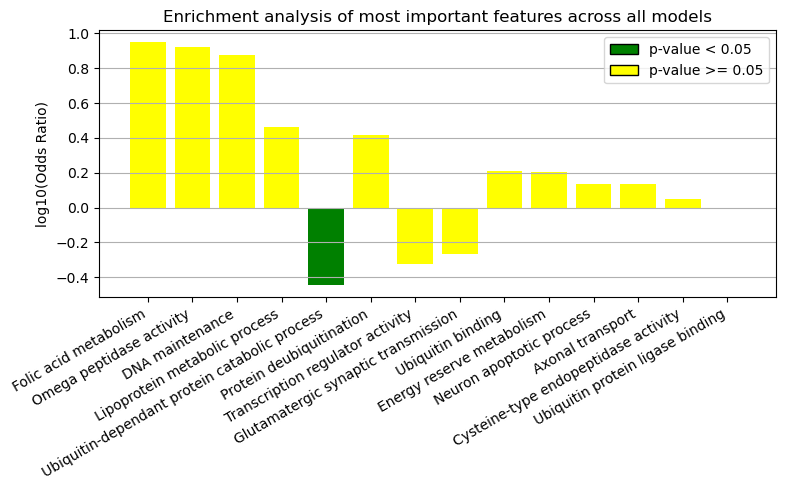

In [30]:
from matplotlib.patches import Patch

# Plot the bar plot
plt.figure(figsize=(8, 5))
plt.bar(combined_hist.index, combined_hist['odds'], color=colors)
plt.ylabel('log10(Odds Ratio)')
plt.title('Enrichment analysis of most important features across all models')
plt.grid(axis='y')

# Rotate x-axis labels if necessary
plt.xticks(rotation=30, ha='right')

# Create a custom legend
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='p-value < 0.05'),
    Patch(facecolor='yellow', edgecolor='black', label='p-value >= 0.05')
]
plt.legend(handles=legend_elements, loc='upper right')

# Save and show plot
plt.tight_layout()
plt.savefig(f"{out_dir}go_enrichment_all.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Panell B

Heatmap of CAG root splits

In [6]:
b1_d2_all = pd.read_csv("ml_results/classification/v2/secondary_splits_allxgb1.txt", sep='\t')
b1_d2_all

,Tree,Seed,RootSplit,SecondNodeID,SecondFeature,Gene,SecondSplit,LeafNodeID,Prediction
0,0,10,46.0,0-1,rs2949568,FAN1,-0.00001,0-3,-0.000005
1,0,10,46.0,0-2,rs147659818,ZBTB39,-0.00001,0-5,-0.000196
2,1,10,44.0,1-1,rs6749757,AFF3,2.00000,1-3,-0.000175
3,1,10,44.0,1-2,rs181698399,MAP1LC3B,-0.00001,1-5,0.000157
4,2,10,45.0,2-1,rs12362653,DLG2,-0.00001,2-3,-0.000130
...,...,...,...,...,...,...,...,...,...
77451,1079,9,42.0,1079-2,rs6446182,FHIT,2.00000,1079-5,-0.000644
77452,1094,9,44.0,1094-1,rs2792205,ESR2,2.00000,1094-3,0.003213
77453,1094,9,44.0,1094-2,rs3730647,MDM2,-0.00001,1094-5,-0.001176
77454,1099,9,42.0,1099-1,rs2483229,PRDM16,2.00000,1099-3,0.001121


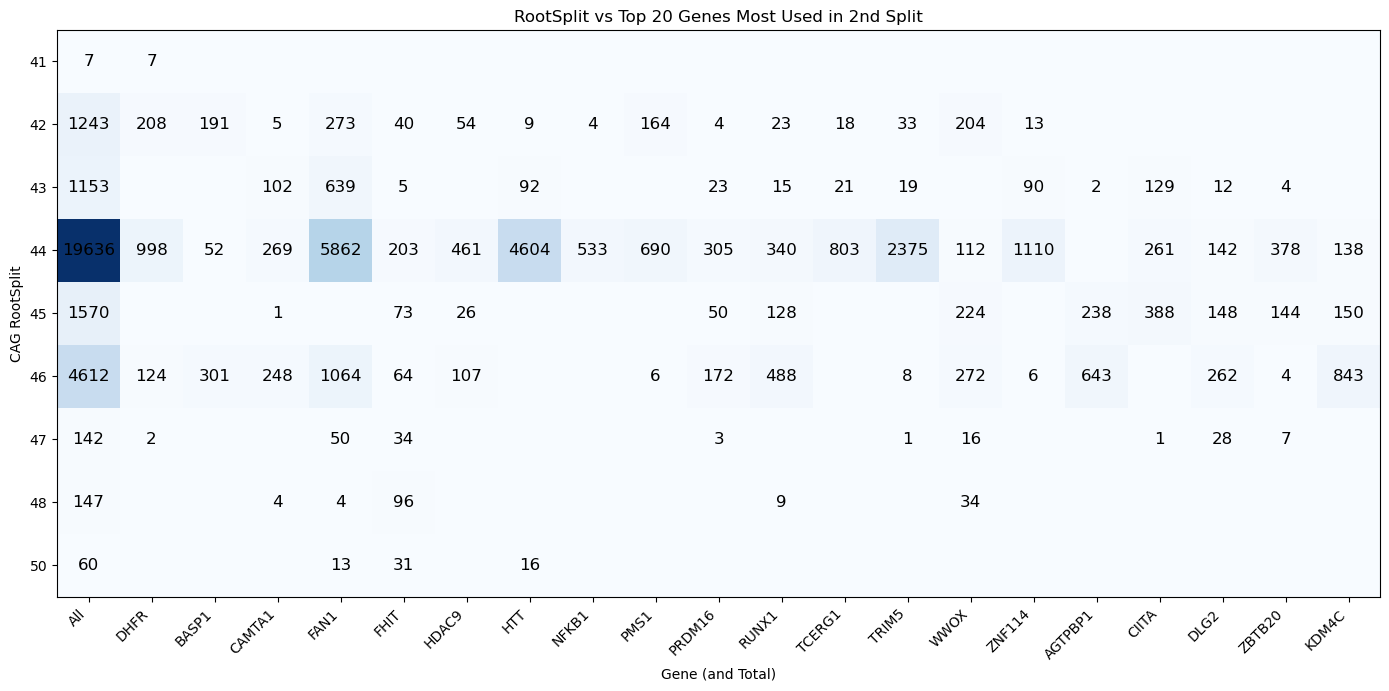

In [11]:
# Top 20 genes by frequency
top_genes_b1_d2_all = b1_d2_all['Gene'].value_counts().head(20).index
fig, ax = rootcag_col_histogram(b1_d2_all, top_genes_b1_d2_all)